In [1]:
!pip install import-ipynb

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for import-ipynb, since package 'wheel' is not installed.
    Running setup.py install for import-ipynb: started
    Running setup.py install for import-ipynb: finished with status 'done'


You should consider upgrading via the 'C:\Users\franc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [90]:
import import_ipynb
%run localisation.ipynb


# Local navigation functions

In [69]:
import tdmclient.notebook
await tdmclient.notebook.start()

Exception: Node lock error

In [91]:
def proximity_cost(prox_horiz, left_side):
    
    '''compute the cost related to the value measured by the proximity sensors when chosing a side
       or the other when in front of an obstacle. If the proximity sensors on have a high value 
       compared to the other, the cost of chosing that side will be higher than chosing the other side
       
       Arguments: prox_horiz : array containing the value of the 7 horizontal prox sensors
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                                     false if we want the cost of chosing the right side
                                     
      Return:     cost associated to the proximity sensor
    '''
    
    #weight of proximitys
    alpha = 0.004
    
    #to evaluate which side is the closest to the obstacle we just do the sum of the two left most proximity sensor and same 
    #for the right, we then simply do the sum
    
    left_prox_sum = prox_horiz[0]+prox_horiz[1]
    right_prox_sum = prox_horiz[3]+prox_horiz[4]
    
    if left_prox_sum>right_prox_sum:
        if left_side:
            return alpha*abs(left_prox_sum-right_prox_sum)
        else:
            return 0
    else:
        if left_side:
            return 0
        else:
            return alpha*abs(left_prox_sum-right_prox_sum)

In [92]:
def goal_side_cost(tm_pos, tm_orient, goal_pos, left_side):
    """compute the cost related to the position of the thymio with respect to it's next goal
       when chosing a side or the other when in front of an obstacle.
       Chosing a side that takes us to away from the next goal results in a higher cost
       
       Arguments: tm_pos     : array with the position coordinates of the thymio
                  tm_orient  : double containing the orientation of the Thymio in rad in 0-2*pi
                  goal_pos   : array with position of the goal     
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                               false if we want the cost of chosing the right side
                                     
      Return:     cost 
    """
    
    
    
    
    #checking if the Thymio is rather oriented along the x or the y axis and pointing to + or - the x pr y axis
    x_oriented_pos = False
    x_oriented_neg = False
    y_oriented_neg = False
    y_oriented_pos = False
    
    if (tm_orient >= 7*math.pi/4 and tm_orient <= 2*math.pi) or (tm_orient <= math.pi/4 and tm_orient >= 0):  
        x_oriented_pos = True
    
    if (tm_orient >= 3*math.pi/4 and tm_orient <= 5*math.pi/4):
        x_oriented_neg = True
    
    if (tm_orient > math.pi/4 and tm_orient < 3*math.pi/4):
        y_oriented_pos = True
    
    if (tm_orient > 5*math.pi/4 and tm_orient < 7*math.pi/4):
        y_oriented_neg = True
    
    
    #computation of the cost
    Betha = 12
    
    #check which of the Thymio or the goal position has the larger x and y coordinate
    x_goal_larger = goal_pos[0] > tm_pos[0]
    y_goal_larger = goal_pos[1] > tm_pos[1]
    
    if x_oriented_pos:
        if y_goal_larger:
            if left_side:
                return 0
            else:
                return Betha*abs(tm_pos[1]-goal_pos[1])
        else:
            if left_side:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
    
        
    if x_oriented_neg:
        if y_goal_larger:
            if left_side:
                return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
    
        
    if y_oriented_pos:
        if x_goal_larger:
            if left_side:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
    
    if y_oriented_neg:
        if x_goal_larger:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
    

In [93]:
def total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, left_side):
    '''
       compute the cost of chosing a side rather than the other when in front of an obstacle

       Arguments: tm_pos     : array with the position coordinates of the thymio
                  tm_orient  : double containing the orientation of the Thymio in rad in 0-2*pi
                  goal_pos   : array with position of the goal     
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                               false if we want the cost of chosing the right side 
                  prox_horiz : array containing the value of the 7 horizontal prox sensors
       
       Return:    total cost
       
    '''
    
    prox_cost = proximity_cost(prox_horiz, left_side)

    goal_cost = goal_side_cost(tm_pos, tm_orient, goal_pos, left_side)
    
    return prox_cost + goal_cost

In [94]:
#returns a bool left_side = 1 if the result is to choose the left direction
def choose_direction(prox_horiz, goal_pos, tm_pos, tm_orient):
    """
        choose on which direction we should go when in front of an obstacle
        
        Arguments: prox_horiz : array of horizontal proximity sensors values
                   goal_pos   : array of coordinated of the goal position
                   tm_pos     : array of coordinates of the thymio position
                   tm_orient  : double of the thymio orientation in rad in 0-2pi
        Returns:   left_side  : bool that is true if we should go to the left side, false if should go
                                to the right side.
    """
    left_side = False
    
    left_cost = total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, True)
    
    right_cost = total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, False)
        
    if left_cost < right_cost:
        left_side = True

    return left_side

In [95]:
def obstacle_detected(proximity_sensor, OBST_THRESH=2000):
    """
        determine if an obstacle is detected by the proximity sensor provided in the argument
        
        Arguments: proximity_sensor: double containing the value of the inquired sensor
                   OBST_THRESH     : threshold at which we consider an obstacle is detected
        Return:    obstacle        : bool, True if an obstacle is detected, False otherwise
    """

    obstacle = False
    
    if proximity_sensor >= OBST_THRESH:
            obstacle = True
    
    return obstacle


In [96]:
def path_to_goal_free(tm_orient, tm_pos, goal_pos, proximity_sensors):
    """
        determines if in the general direction of the goal, i.e. left, right or front, an obstacle 
        is in the way, hence if the path to goal is free.
        
        Argument:  tm_orient  : double of the thymio orientation in rad in 0-2pi
                   tm_pos     : array of coordinates of the thymio position
                   proximity_sensors : array of horizontal proximity sensors values
                   goal_pos   : array of coordinated of the goal position
                       
    """
    
    #the goal direction is obstacle free
    goal_clear = True
    
    #determine where is the obstacle with respect to the Thymio
    goal_front = False
    goal_right = False
    goal_left = False
    
    #We start by getting the angle between the x-axis and the vector connecting the goal to the thymio
    theta = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    
    if theta < 0:
        theta += math.pi*2
        
    
    #checking position of goal with respect to thymio view angle
    
    #We start by checking if the thymio is in the visibility of the proximity sensors view angle
    if tm_orient >= math.pi/4 and tm_orient <= 7*math.pi/4:
        
        
        if theta >= tm_orient-math.pi/4 and theta <= tm_orient+math.pi/4:
            goal_front = True
            #print("FRONT1")
            
            
    if tm_orient >= 0 and tm_orient < math.pi/4:
        
        if (theta >= 0 and theta <= tm_orient+math.pi/4) or (theta>= 7*math.pi/4):
            goal_front = True
            #print("FRONT2")
    
    if tm_orient > 7*math.pi/4:
        
        if (theta >= tm_orient-math.pi/4) or (theta <= tm_orient- 7*math.pi/4):
            goal_front = True
            #print("Front3")
    
    #checking if the goal is on the left or right side of the robot
    if tm_orient <= math.pi and (not goal_front):
        if theta >= tm_orient and theta <=math.pi+tm_orient:
            goal_left = True
            
        else:
            goal_right = True
            #print("Right")
    
    if tm_orient > math.pi and (not goal_front):
        if theta >= tm_orient-math.pi and theta < tm_orient:
            goal_right = True
            #print("left")
        else:
            goal_left = True
            #print("right")
            
    #now that the position of the robot with respect to the robot angle of vision is determined, we can determine if there is an obstacle
    #Threshold for obstacle on the side
    THRESH_SIDE = 1500
    #Threshold for obstacle detection on front
    THRESH_FRONT_CENTRAL = 1500 #Threshold for central prox
    THRESH_FRONT_SIDE = 1700   #Threshold for the prox between central and outest
    THRESH_FRONT_OUTEST = 2000 #Thresjold for outest proximity sensors
    
     
    
    if goal_front:

        if (obstacle_detected(proximity_sensors[2],THRESH_FRONT_CENTRAL) or 
            obstacle_detected(proximity_sensors[3],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[1],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[0],THRESH_FRONT_OUTEST) or
            obstacle_detected(proximity_sensors[4],THRESH_FRONT_OUTEST)):
            
            goal_clear = False
            #print("obst front")
            
    if goal_left:
        if obstacle_detected(proximity_sensors[0],THRESH_SIDE):
            
            goal_clear = False
            #print("obst left")
    
    if goal_right:
         if obstacle_detected(proximity_sensors[4],THRESH_SIDE):
            
            goal_clear = False
            #print("obst right")
            
    return goal_clear

In [97]:
#PID controller for following the profile of an obstacle on the right of the robot
past_err2 = 0
past_err3 = 0
past_err4 = 0
past_prox2 = 0
past_prox3 = 0
past_prox4 = 0

def right_obst_follow(reset):
    """
        computes the speed to assign to the thymio motor to follow an obstacle on the right side of
        the Thymio with a PID controller
        
        Argument: reset: bool: true if we must reset the past error terms of the integrator term
                               and reset the past value of the prox sensor for the derivative
                               Typically a reset must be done each time we follow a new obstacle
        return:  2 dim vector containing the speeds to assign to the motor in format (right, left)
    """
    global past_err2, past_err3, past_err4, past_prox2, past_prox3, past_prox4
    
    PROX_SCALING = 200
    
    Prox2_obj = 0
    Prox3_obj = 0
    Prox4_obj = 2000
    speed0 = 150

    #PID constants for each  proximity sensor
    Kp_2 = 6
    Ki_2 = 1
    Kd_2 = -5
    
    Kp_3 = 5
    Ki_3 = 1
    Kd_3 = -3
    
    Kp_4 = 3
    Ki_4 = 1
    Kd_4 = -5
    
    if reset:
        past_err2 = 0
        past_err3 = 0
        past_err4 = 0
        past_prox2 = 0
        past_prox3 = 0
        past_prox4 = 0
    
    #implementation of the proportional controller
    error2 = (Prox2_obj-prox_horizontal[2])
    error3 = (Prox3_obj-prox_horizontal[3])
    error4 = (Prox4_obj-prox_horizontal[4])
    
    speedP2 = (Kp_2*error2)//PROX_SCALING
    
    speedP3 = (Kp_3*error3)//PROX_SCALING
    
    speedP4 = (Kp_4*error4)//PROX_SCALING
    
    #print("speed prop:")
    #print(speedP2)
    #print(speedP3)
    #print(speedP4)
   
    #implementation of the derivative controller
    speedD2 = (Kd_2*(prox_horizontal[2]-past_prox2))//PROX_SCALING
    speedD3 = (Kd_3*(prox_horizontal[3]-past_prox3))//PROX_SCALING
    speedD4 = (Kd_4*(prox_horizontal[4]-past_prox4))//PROX_SCALING
    
    print("Speed derivative:")
    print(speedD2)
    print(speedD3)
    print(speedD4)
   
    
    past_prox2 = prox_horizontal[2]
    past_prox3 = prox_horizontal[3]
    past_prox4 = prox_horizontal[4]
    
    #implementation of the integral term with antireset windup
    speedI2 = Ki_2*past_err2//3
    speedI3 = Ki_3*past_err3//3
    speedI4 = Ki_4*past_err4//3
    
    #print("speed integral")
    #print(speedI2)
    #print(speedI3)
    #print(speedI4)
    
    past_err2 += error2
    past_err3 += error3
    past_err4 += error4
    
    past_error_max = 15
    if past_err2 > past_error_max:
        past_err2 = past_error_max
    if past_err2 < -past_error_max:
        past_err2 = -past_error_max
        
    if past_err3 > past_error_max:
        past_err3 = past_error_max
    if past_err3 < -past_error_max:
        past_err3 = -past_error_max
        
    if past_err4 > past_error_max:
        past_err4 = past_error_max
    if past_err4 < -past_error_max:
        past_err4 = -past_error_max
        
    
    speed_PID = speedP2+speedP3+speedP4+speedD2+speedD3+speedD4+speedI4+speedI2+speedI3
    speed_right = speed0-speed_PID
    #print("speed_right")
    
    #print(speed_right)
    speed_left = speed0+speed_PID
    
    #print("speed_left")
    #print(speed_left)
    
    return [speed_right, speed_left]
    

In [98]:
#PID controller to follow an obstacle on the left
past_err0 = 0
past_err1 = 0
past_err2 = 0
past_prox2 = 0
past_prox1 = 0
past_prox0 = 0

def left_obst_follow(reset):
    """
        computes the speed to assign to the thymio motor to follow an obstacle on the left side of
        the Thymio with a PID controller
        
        Argument: reset: bool: true if we must reset the past error terms of the integrator term
                               and reset the past value of the prox sensor for the derivative
                               Typically a reset must be done each time we follow a new obstacle
        return:  2 dim vector containing the speeds to assign to the motor in format (right, left)
    """
    
    global past_err0, past_err1, past_err2, past_prox2, past_prox1, past_prox0
    
    PROX_SCALING = 200
    
    Prox1_obj = 0
    Prox2_obj = 0
    Prox0_obj = 2000
    speed0 = 150

    #PID constants for each  proximity sensor
    Kp_2 = 6
    Ki_2 = 1
    Kd_2 = -5
    
    Kp_1 = 5
    Ki_1 = 1
    Kd_1 = -3
    
    Kp_0 = 3
    Ki_0 = 1
    Kd_0 = -5
     
    if reset:
        past_err2 = 0
        past_err1 = 0
        past_err0 = 0
        past_prox2 = 0
        past_prox1 = 0
        past_prox0 = 0
    
    #implementation of the proportional controller
    error2 = (Prox2_obj-prox_horizontal[2])
    error1 = (Prox1_obj-prox_horizontal[1])
    error0 = (Prox0_obj-prox_horizontal[0])
    
    speedP2 = (Kp_2*error2)//PROX_SCALING
    speedP1 = (Kp_1*error1)//PROX_SCALING
    speedP0 = (Kp_0*error0)//PROX_SCALING
  
    
    #implementation of the derivative controller
    speedD2 = (Kd_2*(prox_horizontal[2]-past_prox2))//PROX_SCALING
    speedD1 = (Kd_1*(prox_horizontal[1]-past_prox1))//PROX_SCALING
    speedD0 = (Kd_0*(prox_horizontal[0]-past_prox0))//PROX_SCALING
  
    past_prox2 = prox_horizontal[2]
    past_prox1 = prox_horizontal[1]
    past_prox0 = prox_horizontal[0]
    
    #implementation of the integral term with antireset windup
    speedI2 = Ki_2*past_err2//3
    speedI1 = Ki_1*past_err1//3
    speedI0 = Ki_0*past_err0//3

    
    past_err2 += error2
    past_err1 += error1
    past_err0 += error0
    
    past_error_max = 15
    if past_err2 > past_error_max:
        past_err2 = past_error_max
    if past_err2 < -past_error_max:
        past_err2 = -past_error_max
        
    if past_err1 > past_error_max:
        past_err1 = past_error_max
    if past_err1 < -past_error_max:
        past_err1 = -past_error_max
        
    if past_err0 > past_error_max:
        past_err0 = past_error_max
    if past_err0 < -past_error_max:
        past_err0 = -past_error_max
        
 
    speed_PID = speedP2+speedP1+speedP0+speedD2+speedD1+speedD0+speedI1+speedI2+speedI0
    speed_right = speed0+speed_PID
    speed_left = speed0-speed_PID
    

    
    return [speed_right, speed_left]
    
   

speeds
[143, 135]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[197, 185]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[170, 181]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[170, 184]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[175, 184]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[167, 162]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[170, 185]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[162, 174]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[165, 180]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[196, 201]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

speeds
[181, 195]
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats

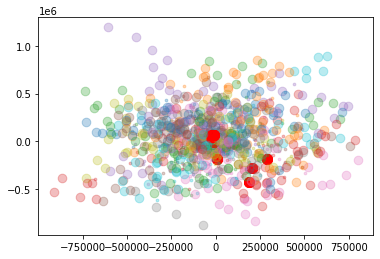

'\nprox_horiz = prox_horizontal\n\n\ncoords = pose.get_coords()\nprint("coord 1")\nprint(coords)\nGo_left = choose_direction(prox_horiz, (1500, 0), (coords[\'x\'],coords[\'y\']), coords[\'theta\'])\n\nfollow_obst = True\nprox_grnd = prox_ground_delta\nsleep(dt)\npose.update([speeds_init,speeds_init], prox_grnd, 300)\ncoords = pose.get_coords()\nprint("coord2")\nprint(coords)\n\nreset = True\ni = 0  #count number of iteration in the loop\nfree_path_iter = 0 #number of consecutive iteration with a clear path\nspeeds = [0,0]\nwhile follow_obst:    \n    \n    prox = prox_horizontal\n    print(prox)\n    if i != 0:\n        reset = False\n    \n    if Go_left:\n        #if turn left obstacle is on the rigth\n        speeds = right_obst_follow(reset)\n        motor_right_target = speeds[0]\n        motor_left_target = speeds[1]\n        #print("LEFT")\n        \n    else:\n        speeds = left_obst_follow(reset)\n        motor_right_target = speeds[0]\n        motor_left_target = speeds[1]

In [113]:
#putting everything together
#putting together functions
obstacle = False
ITER_PATH_FREE = 9 #number of iteration where the path to the goal is free before we stop following the obstacle
speeds_init = 180
THRESHOLD_PROX2 = 1500
THRESHOLD_PROX1 = 1700
THRESHOLD_PROX3 = 1700
THRESHOLD_PROX0 = 2500
THRESHOLD_PROX4 = 2500
dt = 0.3
motor_left_target = speeds_init
motor_right_target = speeds_init
pose = Pose(500,500,0)

i = 0
while i <= 10:#not obstacle:  
    i += 1
    prox = prox_horizontal
    obstacle = obstacle or obstacle_detected(prox[2], THRESHOLD_PROX2)
    obstacle = obstacle or obstacle_detected(prox[1], THRESHOLD_PROX1)
    obstacle = obstacle or obstacle_detected(prox[3], THRESHOLD_PROX3)
    obstacle = obstacle or obstacle_detected(prox[0], THRESHOLD_PROX0)
    obstacle = obstacle or obstacle_detected(prox[4], THRESHOLD_PROX4)
   
    sleep(dt)
    
    prox_grnd = prox_ground_delta
    speeds_meas = [motor_left_speed,motor_right_speed]
    print("speeds")
    print(speeds_meas)
    pose.update(speeds_meas, prox_grnd, 1000*dt)
    pose.plot()

motor_left_target = 0
motor_right_target = 0
sleep(0.3)
plt.show()
"""
prox_horiz = prox_horizontal


coords = pose.get_coords()
print("coord 1")
print(coords)
Go_left = choose_direction(prox_horiz, (1500, 0), (coords['x'],coords['y']), coords['theta'])

follow_obst = True
prox_grnd = prox_ground_delta
sleep(dt)
pose.update([speeds_init,speeds_init], prox_grnd, 300)
coords = pose.get_coords()
print("coord2")
print(coords)

reset = True
i = 0  #count number of iteration in the loop
free_path_iter = 0 #number of consecutive iteration with a clear path
speeds = [0,0]
while follow_obst:    
    
    prox = prox_horizontal
    print(prox)
    if i != 0:
        reset = False
    
    if Go_left:
        #if turn left obstacle is on the rigth
        speeds = right_obst_follow(reset)
        motor_right_target = speeds[0]
        motor_left_target = speeds[1]
        #print("LEFT")
        
    else:
        speeds = left_obst_follow(reset)
        motor_right_target = speeds[0]
        motor_left_target = speeds[1]
    
  
    coords = pose.get_coords()
    print("coords3")
    print(coords)
    
    if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), (800,500),prox):
        free_path_iter += 1
        #print("FREE")
        
        if free_path_iter > ITER_PATH_FREE:
                follow_obst = False
    else:
        free_path_iter = 0
        #print("not free")
    
    print("iter")
    print(free_path_iter)
    
    i += 1
    sleep(dt)
    prox_grnd = prox_ground_delta
    
    pose.update([motor_left_speed,motor_right_speed], prox_grnd, 300)
    coords = pose.get_coords()
    print("coord 4")
    print(coords)
    
sleep(dt)


motor_left_target = 0
motor_right_target = 0
#pose.plot()
"""

In [112]:
motor_left_target = 0
motor_right_target = 0


Current position:
x = 		-27222.1
y = 		-56706.81
theta = 	3.24



True

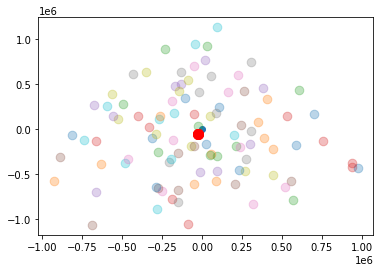

In [110]:
print(pose)
plt.scatter(500,500)
pose.plot(plot_theta=False)
pose.isLost

In [28]:
prox_ground_delta

[313, 223]